# 3.3 성능 측정

## 3.3.0 복습

In [1]:
## 기본

import warnings
warnings.filterwarnings('ignore')

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# MNIST 데이터셋 불러오기
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# 데이터셋 분리
X, y = mnist['data'], mnist['target']

# 샘플 데이터 (숫자 5)
some_digit = X[0]

# 레이블 데이터 타입 변환(문자열 -> 숫자)
y = y.astype(np.uint8)

# 테스트 세트 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print('done')

done


In [2]:
# 그림을 저장할 위치
PROJECT_ROOT_DIR = "../"
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 그림 저장 함수
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
## 이진 분류

# 타깃 벡터 생성
y_train_5 = (y_train == 5) # 5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

# 이진 분류기 모델 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

print('done')

done


In [4]:
sgd_clf.predict([some_digit])

array([ True])

<br>

## 3.3.1 교차 검증을 사용한 정확도(Accuracy) 측정

- 교차 검증은 모델을 평가하는 좋은 방법이다.

<br>

### 3.3.1.1 교차 검증 구현

- 가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어해야 할 필요가 있다.
- 이때는 교차 검증 기능을 직접 구현하면 된다.
- 다음 코드는 사이킷런의 `cross_val_score()` 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력한다.

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


<br>

- `StratifiedKFold` 는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다.
- 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든다.
- 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력한다.

<br>

### 3.3.1.2 `cross_val_score()`를 통한 모델 평가

- `cross_val_score()` 함수로 폴드가 3개인 k-겹 교차 검증을 사용해 `SGDClassifier` 모델을 평가한다.

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

<br>

- 모든 교차 검증 폴드에 대해 **정확도(accuracy, 정확한 예측의 비율)**가 95% 이상이다.

<br>

### 3.3.1.3 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기

In [7]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

<br>

- 더미 분류기의 정확도 측정

In [8]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

<br>

- 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%이다.

<br>

- 사이킷런의 더미 분류기 클래스를 사용하여서도 더미 분류기를 생성할 수 있다.

In [9]:
from sklearn.dummy import DummyClassifier

# 0.24 버전부터 strategy의 기본값이 'stratified'에서 'prior'로 바뀌므로 명시적으로 지정한다.
dmy_clf = DummyClassifier(strategy='prior')
cross_val_score(dmy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

<br>

### 3.3.1.4 정확도(accuracy)의 한계

- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다.
- 특히 **불균형한 데이터셋**을 다룰 때(즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그렇다.

<br>

## 3.3.2 오차 행렬(confusion matrix)

- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
  - ex) 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수 -> 오차 행렬의 5행 3열 확인

<br>

### 3.3.2.1 예측값 생성

- 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 만들어야 한다.
  - 테스트 세트로 예측을 만들면 안된다.
- `cross_val_predict()`를 사용하면 된다.

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

<br>

- `cross_val_predict()` 함수는 k-겹 교차 검증을 수행하고 각 테스트 폴드에서 얻은 예측을 반환한다.
- 즉, 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다.  
(깨끗하다 : 모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다.)

<br>

### 3.3.2.2 오차 행렬 생성

- `confusion_matrix()` 함수를 사용해 오차 행렬을 생성한다.
- 타깃 클래스(`y_train_5`)와 예측 클래스(`y_train_pred`)를 넣고 호출한다.

In [10]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

<br>

### 3.3.2.3 오차 행렬의 의미

- 오차 행렬의 행 : **실제 클래스**를 의미
- 오차 행렬의 열 : **예측 클래스**를 의미  
  
  
- 오차 행렬의 **첫 번째 행** : '5 아님' 이미지, **음성 클래스(negative class)**
  - 오차 행렬의 첫 번째 행, 첫 번째 열 : 53,892개를 '5 아님'으로 정확하게 분류, **진짜 음성(true negative, TN)**
  - 오차 행렬의 첫 번째 행, 두 번째 열 : 687개를 '5'라고 잘못 분류, **거짓 양성(false positive, FP)**  
  
  
- 오차 행렬의 **두 번째 행** : '5' 이미지, **양성 클래스(positive class)**
  - 오차 행렬의 두 번째 행, 첫 번째 열 : 1,891개를 '5 아님'으로 잘못 분류, **거짓 음성(false negative, FN)**
  - 오차 행렬의 두 번째 행, 두 번째 열 : 3,530개를 '5'라고 정확하게 분류, **진짜 양성(true positive, TP)**

<br>

### 3.3.2.4 완벽한 분류기

- 완벽한 분류기라면 진짜 양성(TP)과 진짜 음성(TN)만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 된다.

In [11]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

<br>

### 3.3.2.5 오차 행렬 요약 지표

**1) 정밀도(precision)**

- 양성 예측의 정확도
- *양성이라고 예측한 샘플 중 실제 양성 샘플의 비율*

<img src="../img/Ch03/Ch03-03_001.png" style="margin-left:20px;" />

- $TP$ : 진짜 양성의 수
- $FP$ : 거짓 양성의 수  
  
  
- 확실한 양성 샘플 하나만 예측하면 완벽한 정밀도를 얻을 수 있다.
  - 정밀도 = 1/1 = 100%
- 이는 분류기가 다른 모든 양성 샘플을 무시하기 때문에 그리 유용하지 않다.

<br>

**2) 재현율(recall)**

- 분류기가 정확하게 감지한 양성 샘플의 비율
- *실제 양성인 샘플 중 양성으로 예측한 샘플의 비율*
- **민감도(sensitivity)**, 또는 **진짜 양성 비율(true positive rate, TPR)**이라고도 함

<img src="../img/Ch03/Ch03-03_002.png" style="margin-left:20px;" />

- $TP$ : 진짜 양성의 수
- $FN$ : 거짓 음성의 수  
  
  
- 정밀도와 재현율은 함께 사용하는 것이 일반적이다.

<img src="../img/Ch03/Ch03-03_003.png" />

<br>

## 3.3.3 정밀도와 재현율

- 사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.

<br>

### 3.3.3.1 정밀도 (`precision_score()`)

In [12]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

In [13]:
cm = confusion_matrix(y_train_5, y_train_pred)
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1]) # precision = TP / (FP + TP)
precision

0.8370879772350012

<br>

### 3.3.3.2 재현율 (`recall_score()`)

In [14]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

In [15]:
recall = cm[1, 1] / (cm[1, 0] + cm[1, 1]) # recall = TP / (FN + TP)
recall

0.6511713705958311

<br>

### 3.3.3.3 $F_1$ 점수 ($F_1$ score)

- 정밀도와 재현율을 **$F_1$ 점수**라고 하는 하나의 숫자로 만들면 편리할 때가 많다.
- 특히 두 분류기를 비교할 때 좋다.
- $F_1$ 점수는 정밀도와 재현율의 **조화 평균(harmonic mean)**이다.

<img src="../img/Ch03/Ch03-03_004.png" style="margin-left:20px;" />

- $F$ 점수의 일반화된 조화 평균 식은 다음과 같다.
  
<img src="../img/Ch03/Ch03-03_005.png" style="margin-left:20px;" />

- $\beta > 1$ : 재현율이 강조됨
- $\beta < 1$ : 정밀도가 강조됨
- $\beta$가 1일 때의 점수를 $F_1$ 점수라고 한다.

<br>

- $F_1$ 점수를 계산하려면 `f1_score()` 함수를 호출하면 된다.

In [16]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [17]:
f1 = cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2) # f1 = TP / (TP + (FN + FP) / 2)
f1

0.7325171197343847

- 정밀도와 재현율이 비슷한 분류기에서는 $F_1$ 점수가 높다.
- 하지만 이게 항상 바람직한 것은 아니다.
- 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있다.
  - ex1) 어린아이에게 안전한 동영상을 걸러내는 분류기를 훈련시킨다고 가정
    - case1) 좋은 동영상이 조금 제외되고(높은 재현율) 정말 나쁜 동영상이 몇 개 노출(낮은 정밀도)되는 경우
    - case2) 좋은 동영상이 많이 제외되더라도(낮은 재현율) 안전한 것들만 노출(높은 정밀도)되는 경우
    - 해당 경우에는 case2 의 분류기가 선호된다.
- 정밀도와 재현율 모두를 얻을 수는 없다.
  - 정밀도를 올리면 재현율이 줄고, 그 반대도 마찬가지이다.
- 이를 **정밀도/재현율 트레이드오프**라고 한다.

<br>

## 3.3.4 정밀도/재현율 트레이드오프

- `SGDClassifier` 가 분류를 어떻게 결정하는 지 살펴보며 이 트레이드오프를 이해해보자.

<br>

### 3.3.4.1 결정 함수(decision function)

- 이 분류기는 **결정 함수(decision function)**를 사용하여 각 샘플의 점수를 계산한다.
- 이 점수가 임곗값 보다 큰 경우 : 샘플을 양성 클래스에 할당
- 이 점수가 임곗값 보다 작은 경우 : 샘플을 음성 클래스에 할당

<br>

<a id="3342"/>

### 3.3.4.2 결정 임곗값(decision threshold)에 따른 정밀도와 재현율

<img src="../img/Ch03/Ch03-03_006.png" />

- 위 그림에 가장 낮은 점수부터 가장 높은 점수까지 몇 개의 숫자를 나열했다.
- 11개의 샘플 중 숫자 5는 총 6개가 있다.  
  
  
- 결정 임곗값(decision threshold)이 **가운데(두 개의 숫자 5 사이) 화살표**라고 가정
  - 임곗값 오른쪽에 4개의 진짜 양성(TP, 실제 숫자 5)이 있음
  - 임곗값 오른쪽에 1개의 거짓 양성(FP, 실제 숫자 6)이 있음
  - 따라서 해당 임곗값에서 **정밀도**는 80%(=4/5)이다.
  - 실제 숫자 5는 6개이고, 분류기는 4개만 감지했으므로 **재현율**은 67%(=4/6)이다.  
  
  
- 결정 임곗값(decision threshold)을 **높인다고 가정**(오른쪽으로 이동, 숫자 6과 5 사이)
  - 임곗값 오른쪽에 3개의 진짜 양성(TP, 실제 숫자 5)이 있음
  - 임곗값 오른쪽에 거짓 양성(FP, 실제 숫자 5 아님)은 없음
  - 따라서 해당 임곗값에서 **정밀도**는 100%(=3/3)이다.
    - 결정 임곗값을 높인 결과 거짓 양성(FP, 숫자 6)이 진짜 음성이 되어 **정밀도가 증가**한다.
  - 실제 숫자 5는 6개이고, 분류기는 3개만 감지했으므로 **재현율**은 50%(=3/6)이다.
    - 진짜 양성(TP) 하나가 거짓 음성(FN)이 되었으므로 **재현율은 감소**한다.  
  
  
- 결정 임곗값(decision threshold)을 **내린다고 가정**(왼쪽으로 이동, 숫자 9과 5 사이)
  - 임곗값 오른쪽에 6개의 진짜 양성(TP, 실제 숫자 5)이 있음
  - 임곗값 오른쪽에 2개의 거짓 양성(FP, 실제 숫자 2, 6)이 있음
  - 따라서 해당 임곗값에서 **정밀도**는 75%(=6/8)이다.
    - 결정 임곗값을 내린 결과 거짓 양성(FP, 숫자 2)이 추가되어 **정밀도가 감소**한다.
  - 실제 숫자 5는 6개이고, 분류기는 6개를 감지했으므로 **재현율**은 100%(=6/6)이다.
    - 진짜 양성(TP)이 모두 포함되어 **재현율은 증가**한다.  
  
  
**요약**

- 결정 임곗값을 높이면 정밀도는 증가하고, 재현율은 감소한다.
- 결정 임곗값을 낮추면 정밀도는 감소하고, 재현율은 증가한다.

<br>

### 3.3.4.3 예측에 사용한 점수 확인 및 임곗값 지정

- 사이킷런에서 임곗값을 직접 지정할 수는 없다.
- 대신 예측에 사용한 점수는 확인할 수 있다.
- 분류기의 `predict()` 메서드 대신 `decision_function()` 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.
- 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있다.

In [18]:
# some_digit(숫자 5) 샘플에 대한 SGD 분류기의 평가 점수
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

<br>

**임곗값이 0 인 경우**

- `SGDClassifier`의 임곗값이 0 이므로 아래의 코드는 `predict()` 메서드와 같은 결과를 반환한다.

In [19]:
# 임곗값(threshold)이 0 일 경우, 해당 샘플(some_digit, 숫자 5)의 분류기 평가 점수(2164)는 임곗값 보다 크다.
# 그러므로 예측 결과는 True(해당 샘플은 숫자 5 이다.)를 반환한다.
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

<br>

**임곗값이 8000 인 경우**

- 아래의 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여준다.

In [20]:
# 임곗값(threshold)이 8000 일 경우, 해당 샘플(some_digit, 숫자 5)의 분류기 평가 점수(2164)는 임곗값 보다 작다.
# 그러므로 예측 결과는 False(해당 샘플은 숫자 5 가 아니다.)를 반환한다.
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

<br>

<a id="3344" />

### 3.3.4.4 적절한 임곗값 정하기

- 적절한 임곗값을 정하기 위해서는 먼저 `cross_val_predict()` 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.
- `method='decision_function'`을 지정하여 예측 결과가 아니라 결정 점수를 반환받도록 한다.

In [22]:
# 모든 훈련 샘플에 대한 분류기의 평가 점수들
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [23]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

<br>

- 이 점수로 `precision_recall_curve()` 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다.

In [24]:
from sklearn.metrics import precision_recall_curve

# precision_recall_curve()
#  - 매개변수로 실제 레이블(y_train_5)과 분류기의 평가 점수들을 전달
#  - 반환값
#    - 각 샘플들에 대한 정밀도 (precisions)
#    - 각 샘플들에 대한 재현율 (recalls)
#    - 각 샘플들에 대한 결정 임곗값 (thresholds)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [25]:
precisions

array([0.09040123, 0.09038606, 0.09038757, ..., 1.        , 1.        ,
       1.        ])

In [26]:
recalls

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

In [27]:
thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

<br>

- 이제 임곗값의 함수로 정밀도와 재현율을 그릴 수 있다.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

In [29]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)] # 정밀도가 0.90 일 때의 재현율
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # 정밀도가 0.90 일 때의 임곗값

In [30]:
recall_90_precision

0.4799852425751706

In [31]:
threshold_90_precision

3370.0194991439594

그림 저장: precision_recall_vs_threshold_plot


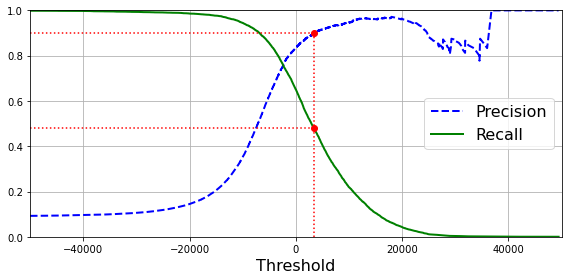

In [32]:
# 결정 임곗값에 따른 정밀도 및 재현율 시각화
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# [3370, 3370], [0, 0.9]
#  --> (3370, 0) -> (3370, 0.9) 직선 그리기
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')
# [-50000, 3370], [0.9, 0.9]
#  --> (-50000, 0.9) -> (3370, 0.9) 직선 그리기
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')
# [-50000, 3370], [0.48, 0.48]
#  --> (-50000, 0.48) -> (3370, 0.48) 직선 그리기
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
# [3370], [0.9]
#  --> (3370, 0.9) 점 그리기 (임곗값이 3370일 때의 정밀도)
plt.plot([threshold_90_precision], [0.9], 'ro')
# [3370], [0.48]
#  --> (3370, 0.48) 점 그리기 (임곗값이 3370일 때의 재현율)
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')

save_fig('precision_recall_vs_threshold_plot')

plt.show()

In [34]:
(y_scores > 0)

array([ True, False, False, ...,  True, False, False])

In [33]:
(y_train_pred == (y_scores > 0))

array([ True,  True,  True, ...,  True,  True,  True])

In [35]:
(y_train_pred == (y_scores > 0)).all()

True

**정밀도 곡선이 울퉁불퉁한 이유**

- 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있다. (일반적으로는 높아져야 함)
- ex) [3.3.4.2](#3342) 그림에서 가운데 임곗값에서 오른쪽으로 숫자 하나만큼 이동하면 정밀도는 감소한다.

<br>

### 3.3.4.5 재현율에 대한 정밀도 곡선

- 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 아래의 그림처럼 재현율에 대한 정밀도 곡선을 그리는 것이다.
- `average_precision_score()` 함수를 사용하면 정밀도/재현율 곡선의 아래 면적을 계산할 수 있어서 서로 다른 두 모델을 비교하는 데 도움이 된다.
- 아래 그림에 표시된 임곗값은 앞에서와 동일하다.

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

그림 저장: precision_vs_recall_plot


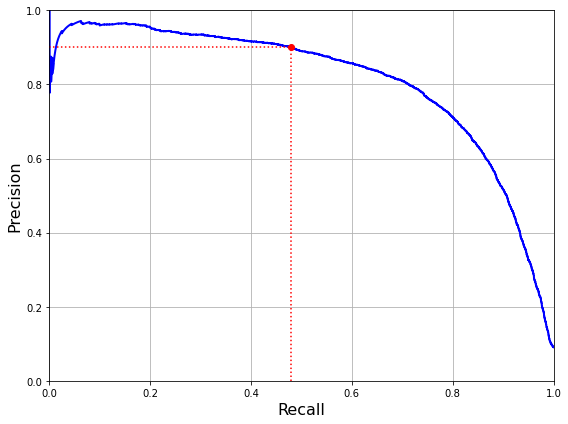

In [37]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

# [0.48, 0.48], [0, 0.9]
#  --> (0.48, 0) -> (0.48, 0.9) 직선 그리기
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
# [0, 0.48], [0.9, 0.9]
#  --> (0, 0.9) -> (0.48, 0.9) 직선 그리기
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
# [0.48], [0.9]
#  --> (0.48, 0.9) 점 그리기 (재현율이 0.48일 때의 정밀도)
plt.plot([recall_90_precision], [0.9], "ro")

save_fig("precision_vs_recall_plot")

plt.show()

- 재현율 80%  근처에서 정밀도가 급격하게 줄어들기 시작한다.
- 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.
  - ex) 재현율이 60% 정도인 지점

<br>

### 3.3.4.6 정밀도 90% 달성하기

- 정밀도 90%를 달성하는 것이 목표라고 가정하자.
- [3.3.4.5](#3345)의 그래프에서 임곗값이 약 8,000 정도라는 것을 알 수 있다.
- 조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있다.
  - `np.argmax()` : 최댓값의 첫 번째 인덱스 반환
  - `np.argmax(precisions >= 0.90)` : 첫 번째 `True` 값

In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439594

<br>

### 3.3.4.7 훈련 세트에 대한 예측

- (훈련 세트에 대한) 예측을 만들려면 분류기의 `predict()` 메서드를 호출하는 대신 다음 코드를 실행한다.

In [39]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

<br>

- 해당 예측에 대한 정밀도와 재현율 확인

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

<br>

- 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 유용하지 않다.

<br>

## 3.3.5 ROC 곡선

### 3.3.5.1 ROC 곡선 이란?

- 수신기 조작 특성 (ROC, Receiver Operating Characteristic) 곡선
- 이진 분류에서 널리 사용하는 도구
- 정밀도/재현율 곡선과 매우 비슷
- ROC 곡선은 **거짓 양성 비율(false positive rate, FPR)**에 대한 **진짜 양성 비율(true positive rate, TPR, 재현율, 민감도)**의 곡선이다.

**cf) 거짓 양성 비율(FPR)**

- 양성으로 잘못 분류된 음성 샘플의 비율
- 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 **진짜 음성 비율(true negative rate, TNR)**을 뺀 값이다.
  - FPR = 1 - TNR
  - TNR을 **특이도(specificity)**라고도 한다.
  - FPR = 1 - 특이도
      
<img src="../img/Ch03/Ch03-03_007.png" style="margin-left:20px;" />

- 그러므로 ROC 곡선은 **민감도(재현율)**에 대한 **1-특이도** 그래프이다.
  - ROC 곡선
    - TPR ~ FPR
    - TPR ~ 1 - TNR

<br>

### 3.3.5.2 ROC 곡선 그리기

- `roc_curve()` 함수를 사용해 여러 임겠값에서 TPR과 FPR을 계산해야 한다.

In [43]:
from sklearn.metrics import roc_curve

# roc_curve()
#  - 매개변수로 실제 레이블(y_train_5)과 분류기의 평가 점수들을 전달
#  - 반환값
#    - 각 샘플들에 대한 거짓 양성 비율 (fpr)
#    - 각 샘플들에 대한 진짜 양성 비율 (tpr)
#    - 각 샘플들에 대한 결정 임곗값 (thresholds)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [44]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99937705, 0.99937705,
       1.        ])

In [45]:
tpr

array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
       9.99815532e-01, 1.00000000e+00, 1.00000000e+00])

In [46]:
thresholds

array([  49442.43765905,   49441.43765905,   36801.60697028, ...,
       -105763.22240074, -106527.45300471, -146348.56726174])

In [15]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR, Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR, Recall)', fontsize=16)
    plt.grid(True)  

그림 저장: roc_curve_plot


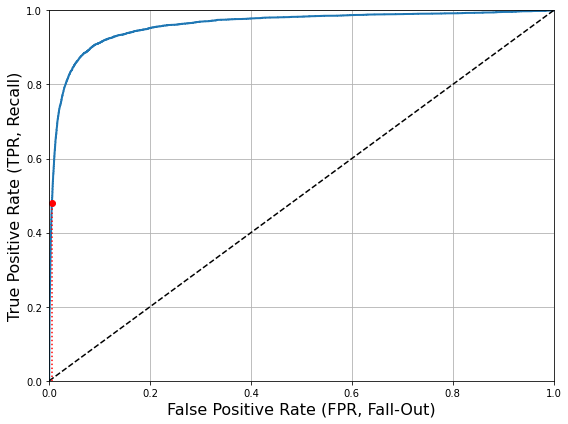

In [47]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

save_fig("roc_curve_plot")

plt.show()

- 모든 가능한 임곗값에서 진짜 양성 비율(TPR)에 대한 거짓 양성 비율(FPR)을 나타낸 ROC 곡선
- 붉은 점이 선택한 비율의 지점이다. (43.68%의 재현율)

<br>

### cf) 더미 분류기의 ROC 곡선 시각화

In [14]:
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]
y_scores_dmy

array([0.09035, 0.09035, 0.09035, ..., 0.09035, 0.09035, 0.09035])

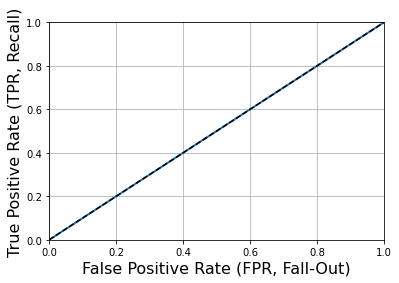

In [18]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

<br>

### 3.3.5.3 TPR/FPR 트레이드오프

- 재현율(TPR)이 높을 수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다.

<br>

### 3.3.5.4 좋은 분류기의 ROC 곡선

- 위 그림에서 점선은 완전한 랜덤 분류기의 ROC 곡선을 의미한다.
- 좋은 분류기는 이 점선에서 왼쪽 위 모서리 방향으로 최대한 멀리 떨어져 있어야 한다.

<br>

### 3.3.5.5 AUC

- **곡선 아래의 면적(area under the curve, AUC)**을 측정하면 분류기들을 비교할 수 있다.
  - 완벽한 분류기 : ROC의 AUC = 1
  - 완전한 랜덤 분류기 : ROC의 AUC = 0.5
    - 랜덤 분류기는 훈련 데이터의 클래스 비율에 따라 무작위로 예측하는 것을 말한다.
    - 사이킷런의 `DummyClassifier`에서 랜덤 분류기를 제공한다.

- 사이킷런은 ROC의 AUC를 계산하는 함수(`roc_auc_score`)를 제공한다.

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<br>

### 3.3.5.6 ROC 곡선 vs 정밀도/재현율 곡선 (PR 곡선)

- 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요한 경우 -> PR 곡선 사용
- 반대의 경우 -> ROC 곡선 사용  
  
  
- ex) 위의 ROC 곡선을 보면 매우 좋은 분류기라 생각할 수 있다.
- 하지만 이는 음성(5 아님)에 비해 양성(5)이 크게 적기 때문이다.
- 이와 다르게 PR 곡선은 분류기의 성능 개선 여지가 얼마나 되는 지(오른쪽 위 모서리에 가까워질 수 있는 지) 잘 보여준다.

<br>

### 3.3.5.7 서로 다른 이진 분류 모델에 대한 AUC 점수 비교

- 먼저 훈련 세트의 샘플에 대한 점수를 얻어야 한다.
  - `SGDClassifier` 는 `decision_function()` 함수를 통해 해당 점수를 얻을 수 있다.
  - `RandomForestClassifier` 는 `decision_function()` 메서드가 없는 대신 `predict_proba()` 메서드가 있다.
  - 사이킷런의 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있다.
  - `predict_proba()` 메서드
    - 샘플이 행, 클래스가 열
    - 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환 (ex. 어떤 이미지가 5일 확률 : 70%)

In [49]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [50]:
y_probas_forest # 0: 음성일 확률, 1: 양성일 확률

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

<br>

- `roc_curve()` 함수는 레이블과 점수를 기대한다.
- 하지만 점수 대신에 클래스 확률을 전달할 수 있다.
- 양성 클래스 확률을 점수로 사용한다.

In [51]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

<br>

- 두 분류기의 ROC 곡선을 함께 시각화

그림 저장: roc_curve_comparison_plot


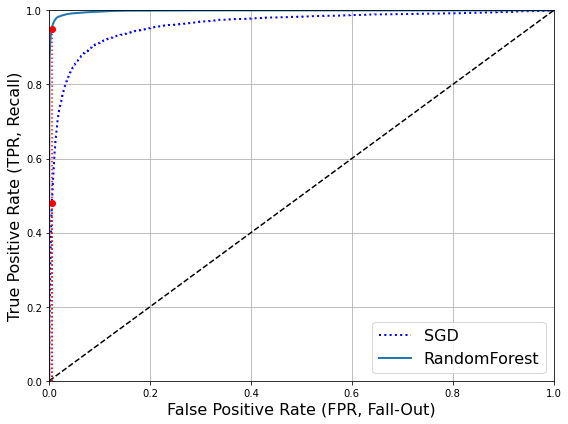

In [52]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RandomForest')

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

save_fig("roc_curve_comparison_plot")

plt.show()

<br>

- `RandomForestClassifier`의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 `SGDClassifier` 보다 훨씬 좋아 보인다.
- 당연하게 ROC AUC 점수도 훨씬 높다.

In [53]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

<br>

- `RandomForestClassifier` 분류기의 정밀도

In [55]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

<br>

- `RandomForestClassifier` 분류기의 재현율

In [56]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591